##Analyzing the funny bone

In [2]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup

In [3]:
jokes_file = 'data/jester_dataset_2/jester_items.dat'
jokes_ratings = 'data/jester_dataset_2/jester_ratings.dat'

jokes = []
hasSeenPtag = False
with open(jokes_file, 'rb') as jkfile:
    joke = ''
    for line in jkfile:
        line = line.strip()#replace('\n', '')
        if line == "<p>":
            hasSeenPtag = True
        if hasSeenPtag:
            joke += line
        if line == "</p>":
            hasSeenPtag = False
            soup = BeautifulSoup(joke)
            joke = soup.find('p').getText()
            jokes.append(joke)
            joke = ''
print len(jokes)

150


In [4]:
ratings_df = pd.read_csv('data/jester_dataset_2/jester_ratings.dat', names=['user', 'joke', 'rating'])
ratings_df.head()

,user,joke,rating
0,1,5,0.219
1,1,7,-9.281
2,1,8,-9.281
3,1,13,-6.781
4,1,15,0.875


In [5]:
spread_of_jokes = ratings_df.groupby('joke').agg([np.std]).rating
spread_of_jokes.sort(columns=['std'], ascending=False).head()

,std
joke,
124,6.083010
140,6.082668
58,6.079473
57,5.951290
123,5.903458


In [6]:
print jokes[123]

Person 1: Hey, wanna hear a great knock-knock joke?Person 2: Sure, What is it?Person 1: Okay, you start.Person 2: Knock-knock.Person 1: Who's there?Person 2: ...Person 1: Hah!


In [15]:
user_v_rating_df = pd.pivot_table(ratings_df, values=['rating'], index=['joke', 'user']).unstack()
user_v_rating_df.head()

rating                                                                 \
user  1      2      3      4      5      6      7      8      9      10      
joke                                                                         
5     0.219 -9.688 -9.844 -5.812  6.906 -0.031 -2.906  6.219  8.250 -5.750   
7    -9.281  9.938 -9.844 -4.500  4.750 -9.094 -2.344 -7.438  9.000  0.281   
8    -9.281  9.531 -7.219 -4.906 -5.906 -0.406 -0.500 -0.812  8.875  0.781   
13   -6.781  9.938 -2.031    NaN -0.406  7.500 -0.969 -3.438  9.750  8.281   
15    0.875  0.406 -9.938    NaN -4.031 -7.219  2.250  0.531  9.375  3.594   

      ...                                                                   \
user  ...    63969  63970  63971  63972  63973  63974  63975  63976  63977   
joke  ...                                                                    
5     ...      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
7     ...   -9.094  9.750 -3.156 -9.844 -4.594 -4.438  0.625 -7.250 -8.531   
8     ...   -7.375 -7.219 -2.812    NaN -4.312  1.531  4.531  4.562 -8.438   
13    ...    9.688 -7.156    NaN    NaN  3.000 -1.438  4.969 -5.594 -9.625   
15    ...    8.062 -8.250    NaN    NaN  3.938 -9.156 -3.375    NaN  6.594   

             
user  63978  
joke         
5       NaN  
7    -7.906  
8    -7.594  
13   -7.594  
15   -6.375  

[5 rows x 59132 columns]

/Users/vmandal/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:1318: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


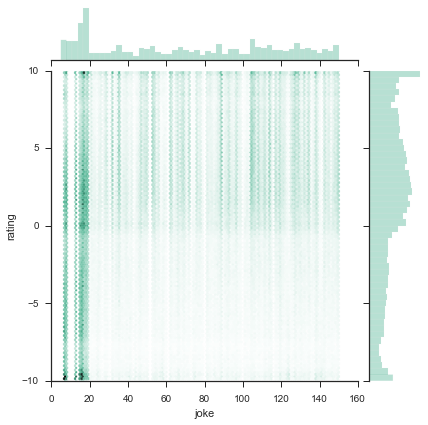

In [16]:
import numpy as np
from scipy.stats import kendalltau
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set(style="ticks")

sns.jointplot(ratings_df.joke, ratings_df.rating, kind="hex", stat_func=None, color="#4CB391")

In [17]:
user_v_rating_df = user_v_rating_df.fillna(0)

In [18]:
from sklearn.metrics.pairwise import cosine_similarity

In [21]:
dists = cosine_similarity(user_v_rating_df)
print user_v_rating_df.shape

(140, 59132)


In [22]:
print dists

[[  1.00000000e+00   4.91772274e-02   3.38706820e-02 ...,   1.17074358e-03
    1.67390960e-04   4.83585221e-04]
 [  4.91772274e-02   1.00000000e+00   3.73989404e-01 ...,  -7.12946308e-02
   -4.84716707e-02  -4.31417100e-02]
 [  3.38706820e-02   3.73989404e-01   1.00000000e+00 ...,   2.76660104e-02
    4.18277847e-02   4.86509771e-02]
 ..., 
 [  1.17074358e-03  -7.12946308e-02   2.76660104e-02 ...,   1.00000000e+00
    4.52850322e-01   4.03752102e-01]
 [  1.67390960e-04  -4.84716707e-02   4.18277847e-02 ...,   4.52850322e-01
    1.00000000e+00   3.45420657e-01]
 [  4.83585221e-04  -4.31417100e-02   4.86509771e-02 ...,   4.03752102e-01
    3.45420657e-01   1.00000000e+00]]


In [23]:
dists = pd.DataFrame(dists, columns=user_v_rating_df.index)

In [24]:
dists.index = dists.columns
dists.ix[0:10, 0:10]

joke,5,7,8
joke,,,
5,1.000000,0.049177,0.033871
7,0.049177,1.000000,0.373989
8,0.033871,0.373989,1.000000


In [37]:
jokes_i_like = [139]
dists[jokes_i_like].head()

joke,139
joke,
5,-0.001682
7,-0.018975
8,0.054869
13,0.035143
15,0.016135


In [38]:
jokes_summed = dists[jokes_i_like].apply(lambda row: np.sum(row), axis=1)
jokes_summed = jokes_summed.order(ascending=False)
jokes_summed.head(15)

joke
139    1.000000
115    0.469042
138    0.439767
109    0.392633
149    0.388530
120    0.374538
93     0.351718
148    0.336148
56     0.325297
127    0.316886
78     0.310257
145    0.304326
39     0.304213
147    0.298696
77     0.294032
dtype: float64

In [39]:
print jokes[139]
print '---------'
print jokes[114]
print '---------'
print jokes[137]

Chuck Norris' calendar goes straight from March 31st to April 2nd; no one fools Chuck Norris.
---------
A lady bought a new Lexus. It cost a bundle. Two days later, she brought it back, complaining that the radio was not working."Madam," said the sales manager, "the audio system in this car is completely automatic. All you need to do is tell it what you want to listen to, and you will hear exactly that!"She drove out, somewhat amazed and a little confused. She looked at the radio and said, "Nelson." The radio responded, "Ricky or Willie?" She was astounded. If she wanted Beethoven, that's what she got. If she wanted Nat King Cole, she got it.She was stopped at a traffic light enjoying "On the Road Again" when the light turned green and she pulled out. Suddenly an enormous sports utility vehicle coming from the street she was crossing sped toward her, obviously not paying attention to the light. She swerved and narrowly missed a collision."Idiot!" she yelled and, from the radio, "Ladies